<a href="https://colab.research.google.com/github/MathPeixoto/NLP-amazon-foods/blob/main/Amazon_Fine_Food_Reviews_All_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon food

In this notebook I will work on a NLP model capable of predicting the food's scored based on the text review that an user has written for this food.

In order to reach this purpose, I have chosen the [Amazon food dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews).

The "score" collumn is the number of rating assigned by an user for the food.
The "text" collumn is the review.

So, let's start.

## Imports

In [ ]:
# Imports used all over the project.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
from nltk.stem import WordNetLemmatizer
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('white')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# I've only installed the stopwords and wordnet identifier
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Package stopwords is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet
      Package wordnet is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

## Basic info about the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
reviews_dataset = pd.read_csv('/content/gdrive/MyDrive/Arquivos/Reviews.csv')
reviews_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
reviews_dataset.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
# I will create a new collumn named "TextLength" that contains the amount of characters of the review text.
reviews_dataset['TextLength'] = reviews_dataset['Text'].apply(len)
reviews_dataset.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TextLength
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509


## Data Visualization and Exploratory Data Analysis

In [ ]:
# It seems that the dataset contains large text reviews.
# Actually the text reviews are grater than 20000 characters.
reviews_dataset.TextLength.describe()

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: TextLength, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe339903668>,
      dtype=object)

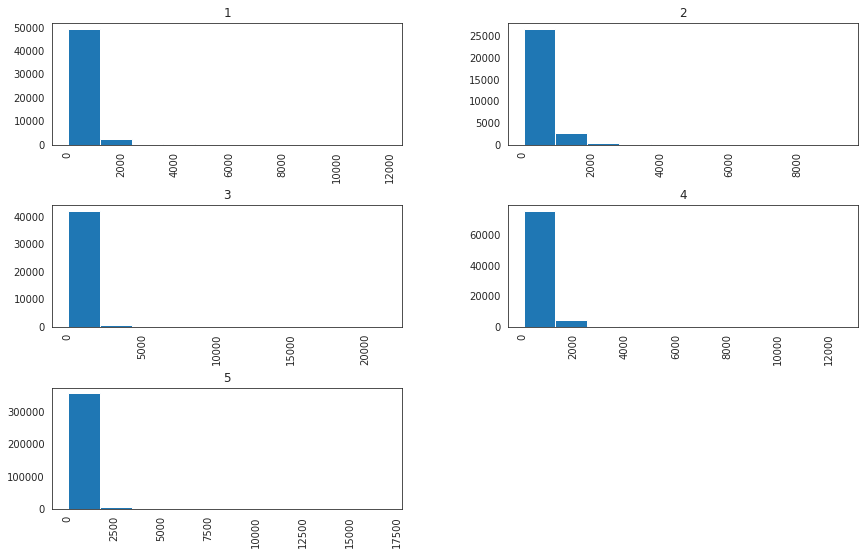

In [ ]:
# The number of characters in a review does not seems to be related with food's score.
reviews_dataset.hist(column='TextLength', by='Score', bins=10, figsize=(14,9))

[Text(0, 0.5, 'Percent')]

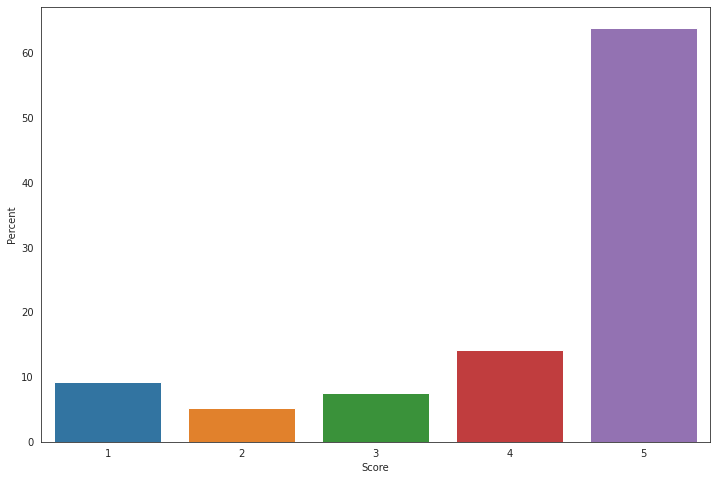

In [ ]:
# Here we can see that 60% of foods are scored with 5 points 
# and aproximately 15% of foods are scored with 4 points. What is pretty good!
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Score", y="Score", data=reviews_dataset, 
                 estimator=lambda x: len(x) / len(reviews_dataset) * 100, )
ax.set(ylabel="Percent")

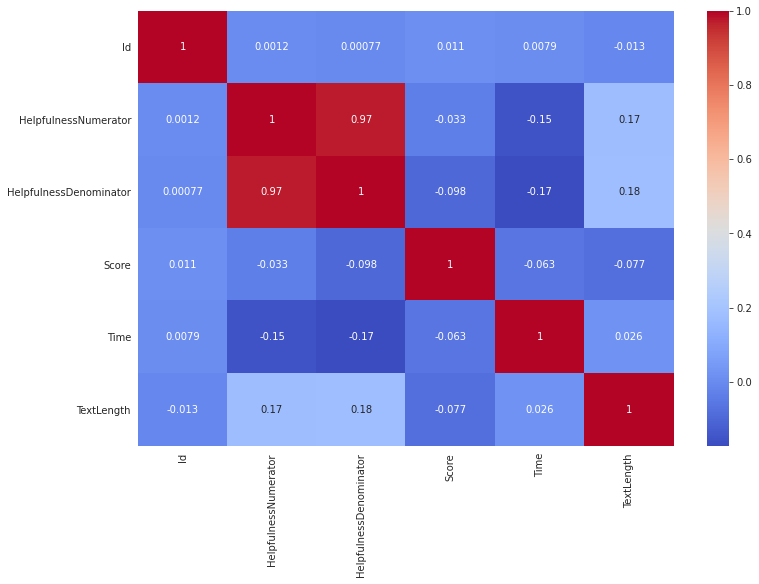

In [ ]:
# Here I can see how the variables are related to each other.
# The HelpfullnessNumerator and HelpfullnessDenominator have a strong crescente linear correlation.
# And that was expected, given that the HelpfullnessNumerator indicates the number of users who found the review helpfull
# and the HelpfullnessDenominator indicates if the users found the review helpful or not. 
# They are very similar features.
plt.figure(figsize=(12,8))
sns.heatmap(reviews_dataset.corr(), cmap='coolwarm', annot=True)

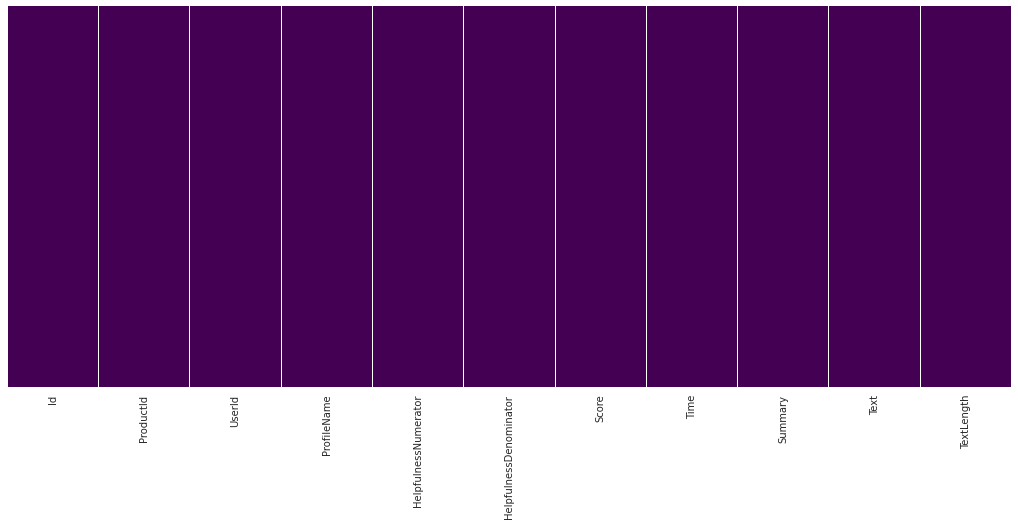

In [ ]:
# It doesn't seem to have any null value in this dataset. If does, it would appear yellow lines.
plt.figure(figsize=(18, 7))
sns.heatmap(reviews_dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Preprocessing

In [ ]:
# Function used to remove punctuations, words very usual and to extract the root of the words.
wordnet_lemmatizer = WordNetLemmatizer()

def text_process(message):
    # Removing punctuations.
    nopunc = [char for char in message if char not in string.punctuation]

    # Putting them together to make a new string.
    nopunc = ''.join(nopunc)

    # Removing the stopwords.
    nostopwords = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

    # Extracting the root of the words.
    words = []
    for word in nostopwords:
      words.append(wordnet_lemmatizer.lemmatize(word.casefold(), pos="v"))

    return words

In [ ]:
# Checking if the functions is working as expected.
reviews_dataset["Text"].head(3).apply(text_process)

0    [buy, several, vitality, can, dog, food, produ...
1    [product, arrive, label, jumbo, salt, peanutst...
2    [confection, around, centuries, light, pillowy...
Name: Text, dtype: object

In [ ]:
text = reviews_dataset["Text"]
score = reviews_dataset["Score"]

In [ ]:
# As I can see, the dataset is unbalanced and this can impact in the model performance.
# There's 29769 scores equal to 2 and 363122 scores equal to 5.
# If the dataset don't be balanced the machine learning model can be highly skewed, what is pretty bad.
np.bincount(score)

array([     0,  52268,  29769,  42640,  80655, 363122])

In [ ]:
# Building the bag of words.
bow_transformer = CountVectorizer(analyzer=text_process).fit(text)

# Number os words in the bag of words.
print(len(bow_transformer.vocabulary_))

229043


In [ ]:
messages_bow = bow_transformer.transform(text)

In [ ]:
# Here I'm balancing the dataset. All classes will be limited to the minority class available, wich is the score equals to 2.
# So I'll have 29769 rows of score available to be used in training and test of the model.
nr = NearMiss()
balanced_text, balanced_score = nr.fit_sample(messages_bow, score)

In [ ]:
# Checking the balance again.
np.bincount(balanced_score)

array([    0, 29769, 29769, 29769, 29769, 29769])

In [ ]:
# Creating the Tf-Idf.
tfidf_transformer = TfidfTransformer().fit(balanced_text)
messages_tfidf = tfidf_transformer.transform(balanced_text)

In [ ]:
# Spliting dataset in train and test variables.
X_train, X_test, y_train, y_test = train_test_split(messages_tfidf, balanced_score,test_size=0.25)

## Trainning the model

In [ ]:
#Normally, the Naive Bayes model has a good performance in NLP, let's try it.
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Metrics of the model

In [ ]:
predictions = nb_model.predict(X_test)

In [ ]:
# Here I can see that the accuracy reached was of 50%. Not so good.
# The f1-score was not so good as well, it can be improved.
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           1       0.42      0.76      0.54      4154
           2       0.85      0.36      0.50     17716
           3       0.38      0.45      0.41      6146
           4       0.38      0.58      0.46      4862
           5       0.49      0.84      0.62      4334

    accuracy                           0.50     37212
   macro avg       0.50      0.60      0.50     37212
weighted avg       0.62      0.50      0.50     37212



In [ ]:
print(confusion_matrix(y_test, predictions))

[[3152 3935  378   53   30]
 [ 365 6295  653   74   20]
 [ 287 3880 2790  328   54]
 [ 180 2289 1563 2798  589]
 [ 170 1317  762 1609 3641]]


## Trying with another classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(messages_tfidf, balanced_score,test_size=0.25)

In [ ]:
# The Random Forest use to be a good choice for NLP too. Let's test it.
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predictions = rf_model.predict(X_test)

In [ ]:
# Definetely Random Forest classifier was a better choice over Naive Bayes classifier for this problem.
# Its accuracy was of 75% and all its f1-score performed better than the Naive Bayes model as well.
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           1       0.83      0.70      0.76      8789
           2       0.64      0.81      0.72      5906
           3       0.59      0.75      0.66      5883
           4       0.71      0.75      0.73      6987
           5       0.96      0.74      0.84      9647

    accuracy                           0.75     37212
   macro avg       0.75      0.75      0.74     37212
weighted avg       0.77      0.75      0.75     37212



In [ ]:
print(confusion_matrix(y_test, predictions))

[[6111  236  325  306  388]
 [1212 4809  812  356  292]
 [ 978  810 4414  839  402]
 [ 428   47  323 5265 1391]
 [  60    4    9  221 7174]]


## Conclusion

In this problem we predict the scores from 1 to 5 based only in the text written, reaching an accuracy of 75%, and that's amazing.
I did a machine learning model to understand when a text related to foods is good or bad and this can be applied in many other areas besides gastronomy.

For example, you can do a sentiment analysis through emails or comments for predicting if a customer is glad or not with your service, you can classify users in social media as potential clients or not based on what they write and so on. The possibilities are huge and you just need to be prepared fot catching them.